In [1]:
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_dataloaders,
  create_foreshock_aftershock_datasets
)

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datasets = create_foreshock_aftershock_datasets(
  num_classes=4,
  # event_split_method='random'
  event_split_method='temporal'
)

Seed set to 42
Seed set to 42


TypeError: append() missing 1 required positional argument: 'values'

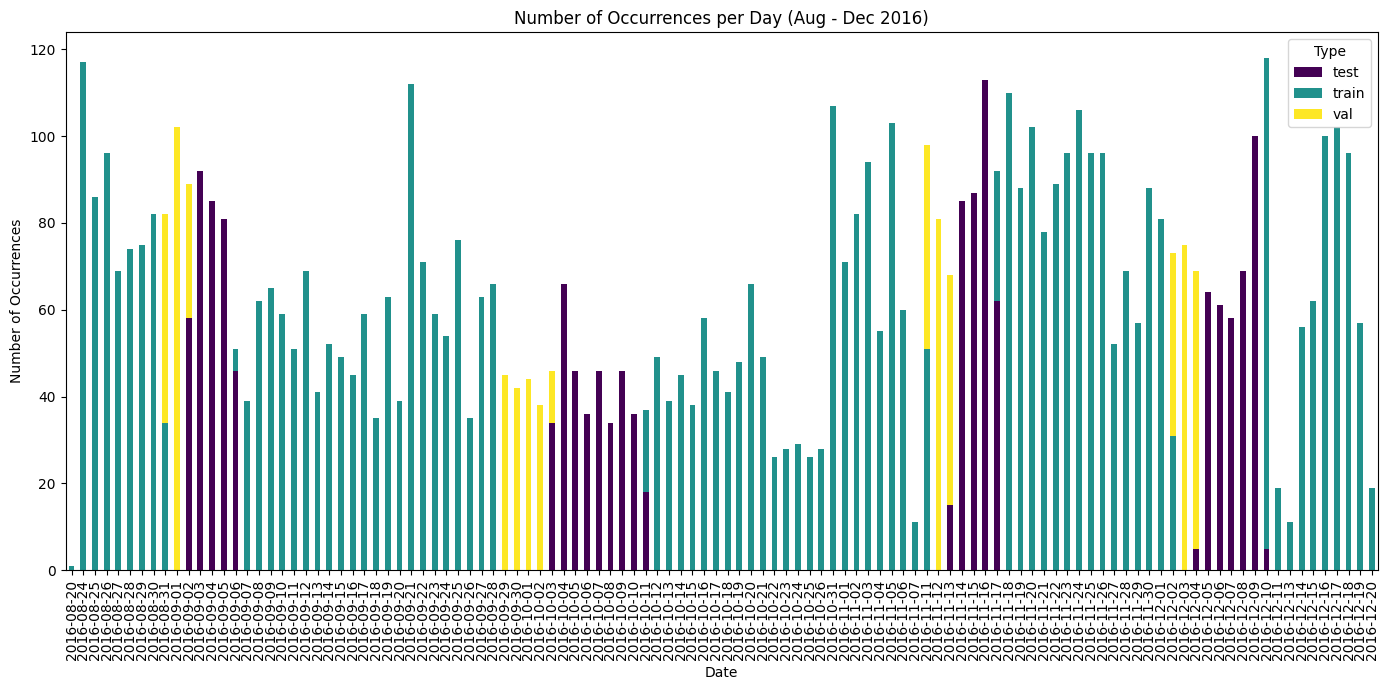

In [ ]:
# datasets['train']['occurence_time']
train_occurence_time = datasets['train']['occurence_time']
val_occurence_time = datasets['val']['occurence_time']
test_occurence_time = datasets['test']['occurence_time']



# Combine all timestamps into a DataFrame
train_df = pd.DataFrame(train_occurence_time, columns=['timestamp'])
train_df['type'] = 'train'
val_df = pd.DataFrame(val_occurence_time, columns=['timestamp'])
val_df['type'] = 'val'
test_df = pd.DataFrame(test_occurence_time, columns=['timestamp'])
test_df['type'] = 'test'

# Concatenate all data
df = pd.concat([train_df, val_df, test_df])

# Extract the date part and count occurrences
df['date'] = df['timestamp'].dt.date
occurrences = df.groupby(['date', 'type']).size().unstack(fill_value=0)

# Plotting
occurrences.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.xlabel('Date')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences per Day (Aug - Dec 2016)')
plt.legend(title='Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
